# Approach-1
Using ML model to get chronological age at death using 549 points.
And getting biological age at CT using the rate factor scaling

## Getting biological age at death estimation
Using points with death label we will calculate biological age at death.

        Biological age at death = harmonic mean(chronological age at death)

In [ ]:
import pandas as pd
import numpy as np
import statistics

df = pd.read_csv('/content/drive/MyDrive/ML760/dfWithMissingDataFilledKNNv1.csv')

df_with_death_label = df.loc[df['y0'].dropna().index]
age_at_CT = df_with_death_label['cl4']*365
death_days_from_CT = df_with_death_label['y0']
age_at_death = age_at_CT + death_days_from_CT

# Harmonic mean of age at death
biological_age_at_death = statistics.harmonic_mean(age_at_death)

print(f'Biological age at death is assumed as fixed for all the patients and is {round(biological_age_at_death / 365.0, 2)} years')

Biological age at death is assumed as fixed for all the patients and is 69.35 years


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Loss function
        L = sum_age[(1 - E[r_age])^2]
    
Note: Here while calculating the loss we assume bio_age and chron_age in days. Chron age is
still at granularity of years as taken from data but bio age is at granularity of days.

In [ ]:
import numpy as np
import math

def custom_loss(biological_age_at_CT, chronological_age_at_CT):
    '''
    Loss is as defined in the above markdown.
    Both inputs are assumed as flat np.arrays.
    Inputs are assumed in days.
    '''
    # bio_age_in_years = np.floor(biological_age_at_CT / 365.0).astype(int)
    chron_age_in_years = np.floor(chronological_age_at_CT / 365.0).astype(int)

    loss = 0
    for i in range(0, 101): # Assuming age is always between 0 to 100
        indexes = np.where(chron_age_in_years == i)
        bio_age_to_consider = biological_age_at_CT[indexes]
        chron_age_to_consider = chronological_age_at_CT[indexes]
        rate_for_age_i = bio_age_to_consider / chron_age_to_consider
        loss_age_i = 0 # If no age in the dataset then no loss value added
        if (len(rate_for_age_i) > 0):
            loss_age_i = 1 - np.mean(rate_for_age_i)
        loss += loss_age_i*loss_age_i

    return loss

## Chronological age prediction using decision trees
- We are using decision trees to predict the chronological age at death.
- After that we will use the predicted age at death to calculate the biological age at CT
- Lastly we will use the custom loss function to see how good the model fit with the assumptions/intuition

### Model using only CT Values

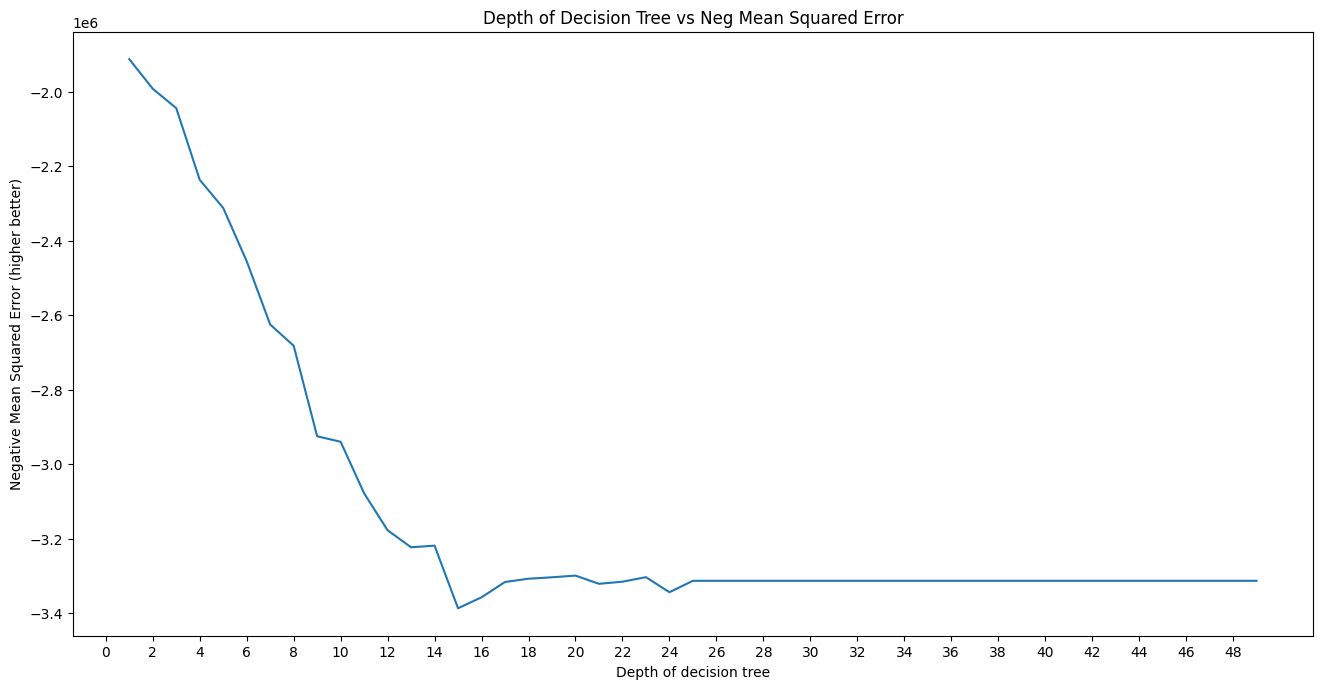

In [ ]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

df = pd.read_csv('/content/drive/MyDrive/ML760/dfWithMissingDataFilledKNNv1.csv')

X = df.iloc[:, 0:11] # CT data only
Y = df.iloc[:, 21:22]
chronological_age_at_CT = df['cl4']*365.0

# Data with death label
Y_index = Y.dropna().index
Y_train = Y.loc[Y_index]
X_train = X.loc[Y_index]

# Prediction data
Y_pred_index = Y[Y['y0'].isnull()].index
X_pred = X.iloc[Y_pred_index]

max_depth = np.array(range(1, 50))
score_arr = np.array([])
for depth in max_depth:
    # Train a decision tree regressor model
    regressor = DecisionTreeRegressor(random_state=0, max_depth=depth)
    regressor.fit(X_train, Y_train)

    # https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html#sklearn.tree.DecisionTreeRegressor.score
    score = cross_val_score(regressor, X_train, Y_train, cv=5, scoring=('neg_mean_squared_error')).mean()
    score_arr = np.append(score_arr, score)

# Plotting max depth vs accuracy score from cross validation
plt.figure(figsize=(16, 8), dpi=100)
plt.plot(max_depth, score_arr)
plt.title('Depth of Decision Tree vs Neg Mean Squared Error')
plt.xlabel('Depth of decision tree')
plt.xticks(np.arange(min(max_depth)-1, max(max_depth)+1, 2))
plt.ylabel('Negative Mean Squared Error (higher better)')
plt.show()

Loss for depth=4 is 15.7


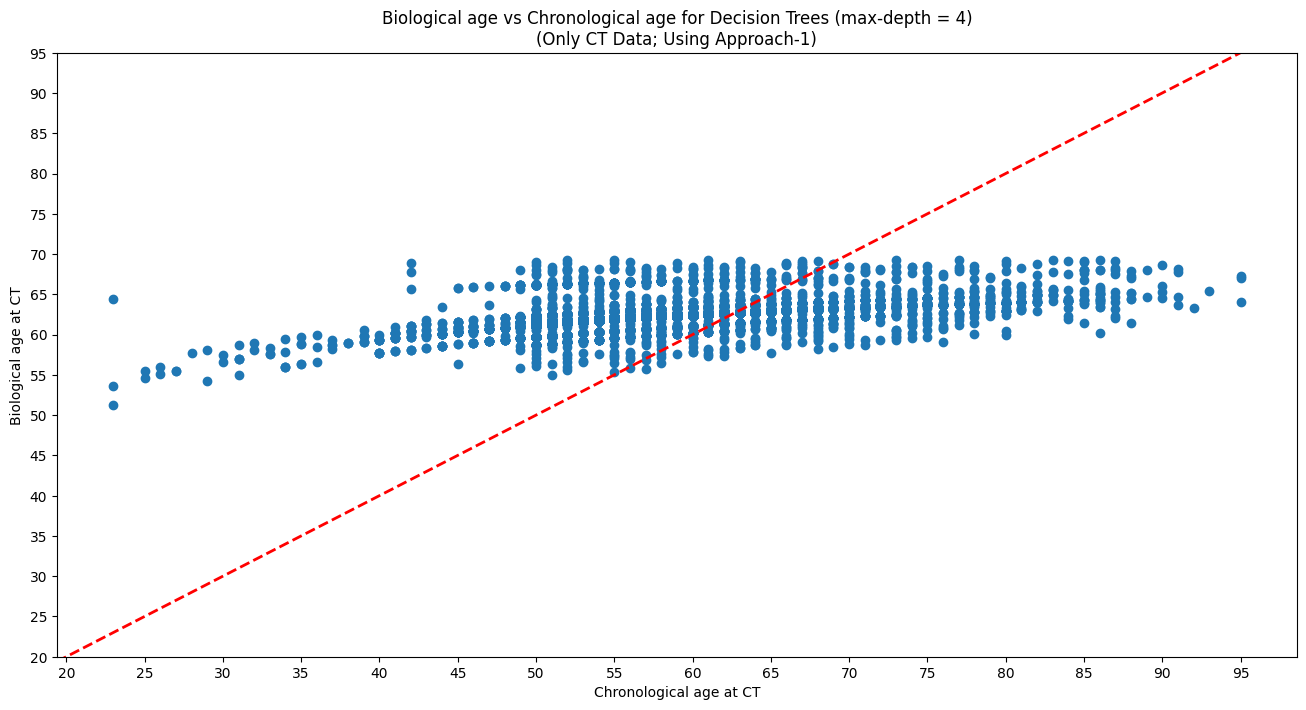

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/ML760/dfWithMissingDataFilledKNNv1.csv')

X = df.iloc[:, 0:11] # CT data only
Y = df.iloc[:, 21:22]
chronological_age_at_CT = df['cl4']*365.0

# Data with death label
Y_index = Y.dropna().index
Y_train = Y.loc[Y_index]
X_train = X.loc[Y_index]

# Prediction data
Y_pred_index = Y[Y['y0'].isnull()].index
X_pred = X.iloc[Y_pred_index]

depth = 4 # Depth of the decision tree
regressor = DecisionTreeRegressor(random_state=0, max_depth=depth)
regressor.fit(X_train, Y_train)

for idx in Y_pred_index:
    y_pred = regressor.predict(X_pred.loc[idx:idx+1])
    Y.loc[idx, 'y0'] = y_pred[0]

# Chronological Age [at Death] values
chronological_age_at_death = chronological_age_at_CT + Y['y0']

# Biological Age [at CT] values
biological_age_at_CT = chronological_age_at_CT * (biological_age_at_death / chronological_age_at_death)

# Loss
loss = custom_loss(np.array(biological_age_at_CT), np.array(chronological_age_at_CT))
print(f'Loss for depth={depth} is {round(loss,2)}')

fig, ax = plt.subplots(1, figsize=(16, 8), dpi=100)
ax.scatter(np.array(chronological_age_at_CT) / 365.0, biological_age_at_CT / 365.0)
plt.xticks(np.arange(20, 100, 5))
plt.yticks(np.arange(20, 100, 5))
plt.xlabel("Chronological age at CT")
plt.ylabel("Biological age at CT")
plt.title(f'Biological age vs Chronological age for Decision Trees (max-depth = {depth})\n(Only CT Data; Using Approach-1)')
xpoints = ypoints = ax.get_xlim()
ax.plot(xpoints, ypoints, linestyle='--', color='red', lw=2, scalex=False, scaley=False)
plt.show()

### Model using CT + Clinical Data

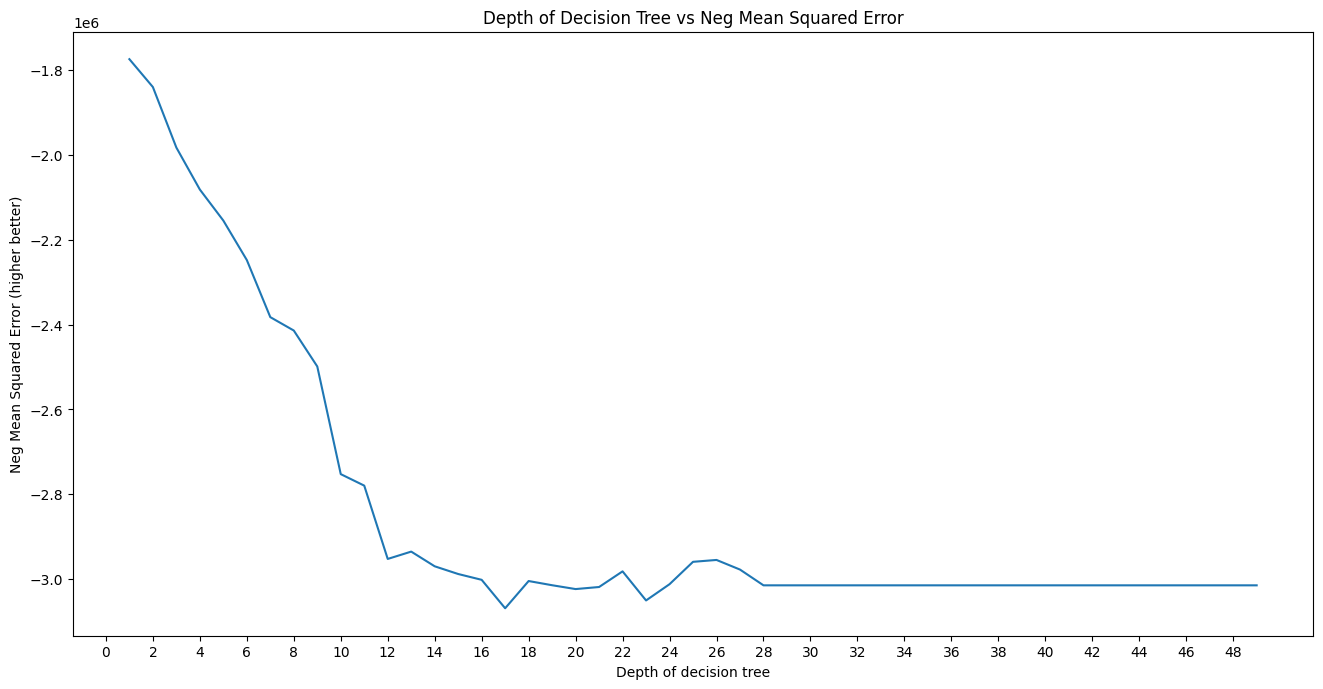

In [ ]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

df = pd.read_csv('/content/drive/MyDrive/ML760/dfWithMissingDataFilledKNNv1.csv')

X = df.iloc[:, 0:21].drop(columns=['cl0']) # CT + Clinical (F/U date dropped)
Y = df.iloc[:, 21:22]
chronological_age_at_CT = df['cl4']*365.0

# Data with death label
Y_index = Y.dropna().index
Y_train = Y.loc[Y_index]
X_train = X.loc[Y_index]

# Prediction data
Y_pred_index = Y[Y['y0'].isnull()].index
X_pred = X.iloc[Y_pred_index]

max_depth = np.array(range(1, 50))
score_arr = np.array([])
for depth in max_depth:
    # Train a decision tree regressor model
    regressor = DecisionTreeRegressor(random_state=0, max_depth=depth)
    regressor.fit(X_train, Y_train)

    # https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html#sklearn.tree.DecisionTreeRegressor.score
    score = cross_val_score(regressor, X_train, Y_train, cv=5, scoring=('neg_mean_squared_error')).mean()
    score_arr = np.append(score_arr, score)

# Plotting max depth vs accuracy score from cross validation
plt.figure(figsize=(16, 8), dpi=100)
plt.plot(max_depth, score_arr)
plt.title('Depth of Decision Tree vs Neg Mean Squared Error')
plt.xlabel('Depth of decision tree')
plt.xticks(np.arange(min(max_depth)-1, max(max_depth)+1, 2))
plt.ylabel('Neg Mean Squared Error (higher better)')
plt.show()

Loss for depth=4 is 16.84


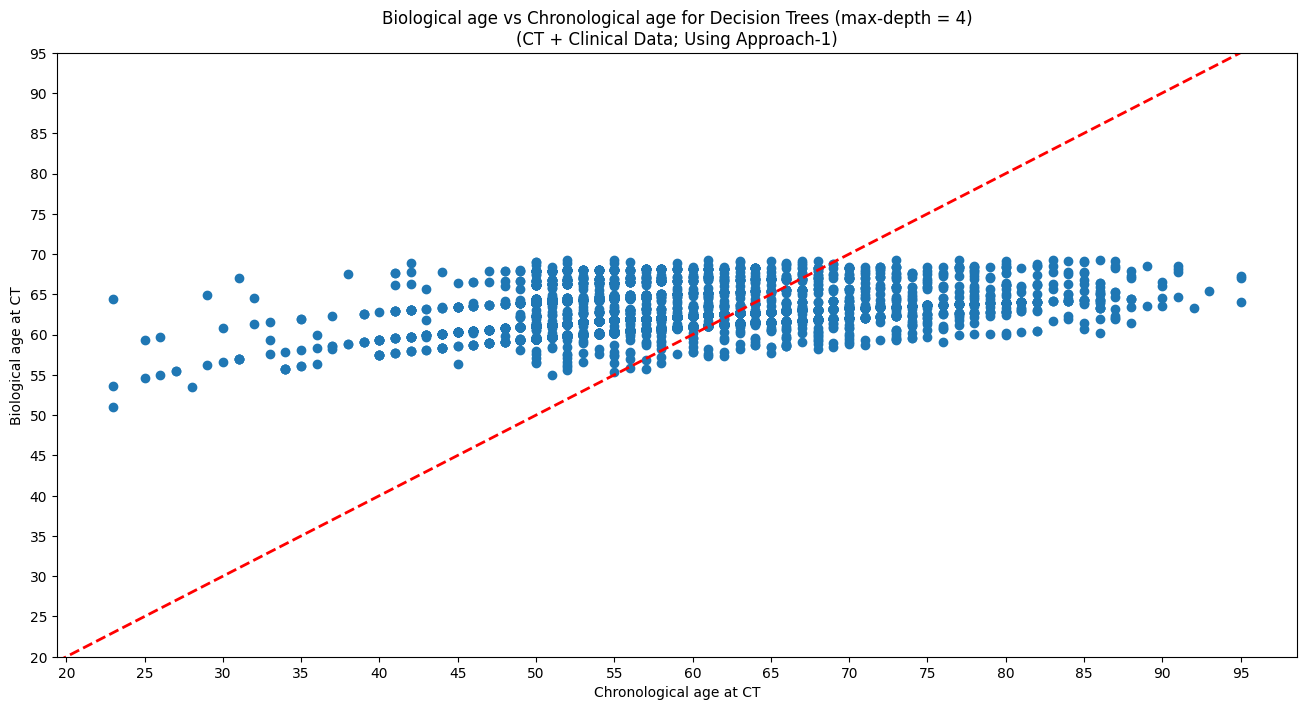

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/ML760/dfWithMissingDataFilledKNNv1.csv')

X = df.iloc[:, 0:21].drop(columns=['cl0']) # CT + Clinical (F/U date dropped)
Y = df.iloc[:, 21:22]
chronological_age_at_CT = df['cl4']*365.0

# Data with death label
Y_index = Y.dropna().index
Y_train = Y.loc[Y_index]
X_train = X.loc[Y_index]

# Prediction data
Y_pred_index = Y[Y['y0'].isnull()].index
X_pred = X.iloc[Y_pred_index]

depth = 4 # Depth of the decision tree
regressor = DecisionTreeRegressor(random_state=0, max_depth=depth)
regressor.fit(X_train, Y_train)

for idx in Y_pred_index:
    y_pred = regressor.predict(X_pred.loc[idx:idx+1])
    Y.loc[idx, 'y0'] = y_pred[0]

# Chronological Age [at Death] values
chronological_age_at_death = chronological_age_at_CT + Y['y0']

# Biological Age [at CT] values
biological_age_at_CT = chronological_age_at_CT * (biological_age_at_death / chronological_age_at_death)

# Loss
loss = custom_loss(np.array(biological_age_at_CT), np.array(chronological_age_at_CT))
print(f'Loss for depth={depth} is {round(loss,2)}')

fig, ax = plt.subplots(1, figsize=(16, 8), dpi=100)
ax.scatter(np.array(chronological_age_at_CT) / 365.0, biological_age_at_CT / 365.0)
plt.xticks(np.arange(20, 100, 5))
plt.yticks(np.arange(20, 100, 5))
plt.xlabel("Chronological age at CT")
plt.ylabel("Biological age at CT")
plt.title(f'Biological age vs Chronological age for Decision Trees (max-depth = {depth})\n(CT + Clinical Data; Using Approach-1)')
xpoints = ypoints = ax.get_xlim()
ax.plot(xpoints, ypoints, linestyle='--', color='red', lw=2, scalex=False, scaley=False)
plt.show()

## Chronological age prediction using neural network
- We are using neural network to predict the chronological age at death.
- After that we will use the predicted age at death to calculate the biological age at CT
- Lastly we will use the custom loss function to see how good the model fit with the assumptions/intuition

### Model using CT data only

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1599: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1599: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conve

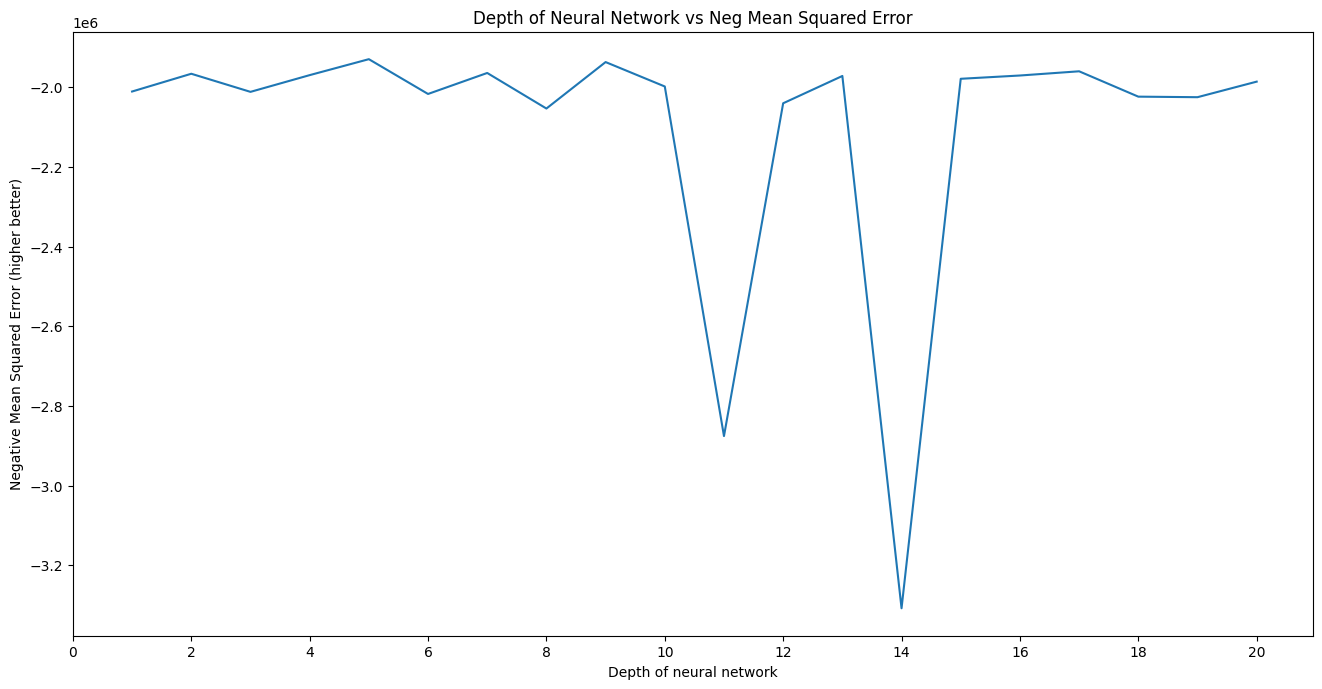

In [ ]:
import numpy as np
import pandas as pd
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

df = pd.read_csv('/content/drive/MyDrive/ML760/dfWithMissingDataFilledKNNv1.csv')

X = df.iloc[:, 0:11] # CT data only
Y = df.iloc[:, 21:22]
chronological_age_at_CT = df['cl4']*365.0

# Data with death label
Y_index = Y.dropna().index
Y_train = Y.loc[Y_index]
X_train = X.loc[Y_index]

# Prediction data
Y_pred_index = Y[Y['y0'].isnull()].index
X_pred = X.iloc[Y_pred_index]

num_layers = np.arange(1, 21)
per_layer_neurons = 10
score_arr = np.array([])
for layer in num_layers:
    hidden_layer_sizes = []
    for j in range(layer):
        hidden_layer_sizes.append(per_layer_neurons)
    # Train a neural network
    regressor = MLPRegressor(hidden_layer_sizes = tuple(hidden_layer_sizes),  max_iter= 500)
    regressor.fit(X_train, Y_train)

    # https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html#sklearn.tree.DecisionTreeRegressor.score
    score = cross_val_score(regressor, X_train, Y_train, cv=5, scoring=('neg_mean_squared_error')).mean()
    score_arr = np.append(score_arr, score)

# Plotting max depth vs accuracy score from cross validation
plt.figure(figsize=(16, 8), dpi=100)
plt.plot(num_layers, score_arr)
plt.title('Depth of Neural Network vs Neg Mean Squared Error')
plt.xlabel('Depth of neural network')
plt.xticks(np.arange(min(num_layers)-1, max(num_layers)+1, 2))
plt.ylabel('Negative Mean Squared Error (higher better)')
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1599: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Loss for layers=8 is 15.65


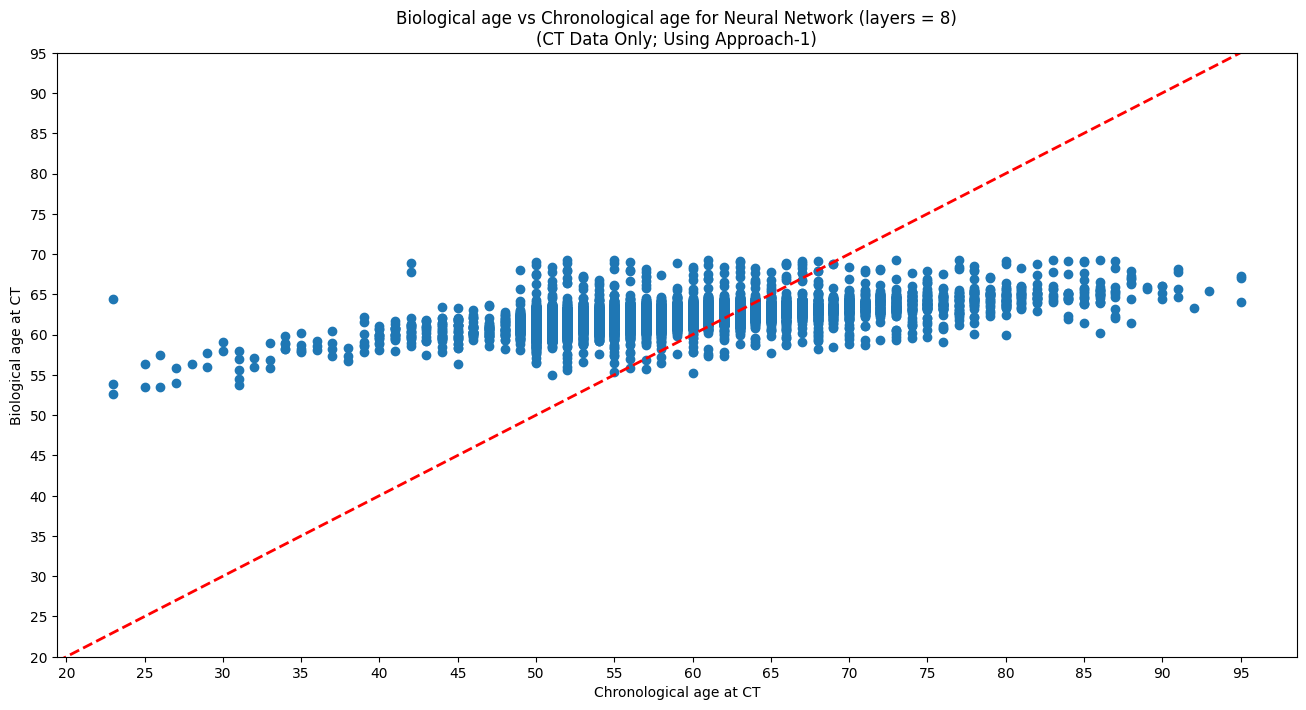

In [ ]:
import numpy as np
import pandas as pd
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

df = pd.read_csv('/content/drive/MyDrive/ML760/dfWithMissingDataFilledKNNv1.csv')

X = df.iloc[:, 0:11] # CT data only
Y = df.iloc[:, 21:22]
chronological_age_at_CT = df['cl4']*365.0

# Data with death label
Y_index = Y.dropna().index
Y_train = Y.loc[Y_index]
X_train = X.loc[Y_index]

# Prediction data
Y_pred_index = Y[Y['y0'].isnull()].index
X_pred = X.iloc[Y_pred_index]

layers = 8
hidden_layer_sizes = []
for j in range(layer):
    hidden_layer_sizes.append(per_layer_neurons)
# Train a neural network
regressor = MLPRegressor(hidden_layer_sizes = tuple(hidden_layer_sizes),  max_iter= 500)
regressor.fit(X_train, Y_train)

for idx in Y_pred_index:
    y_pred = regressor.predict(X_pred.loc[idx:idx+1])
    Y.loc[idx, 'y0'] = y_pred[0]

# Chronological Age [at Death] values
chronological_age_at_death = chronological_age_at_CT + Y['y0']

# Biological Age [at CT] values
biological_age_at_CT = chronological_age_at_CT * (biological_age_at_death / chronological_age_at_death)

# Loss
loss = custom_loss(np.array(biological_age_at_CT), np.array(chronological_age_at_CT))
print(f'Loss for layers={layers} is {round(loss,2)}')

fig, ax = plt.subplots(1, figsize=(16, 8), dpi=100)
ax.scatter(np.array(chronological_age_at_CT) / 365.0, biological_age_at_CT / 365.0)
plt.xticks(np.arange(20, 100, 5))
plt.yticks(np.arange(20, 100, 5))
plt.xlabel("Chronological age at CT")
plt.ylabel("Biological age at CT")
plt.title(f'Biological age vs Chronological age for Neural Network (layers = {layers})\n(CT Data Only; Using Approach-1)')
xpoints = ypoints = ax.get_xlim()
ax.plot(xpoints, ypoints, linestyle='--', color='red', lw=2, scalex=False, scaley=False)
plt.show()

### Model with CT and Clinical Data

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1599: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Loss for layers=5 is 16.13


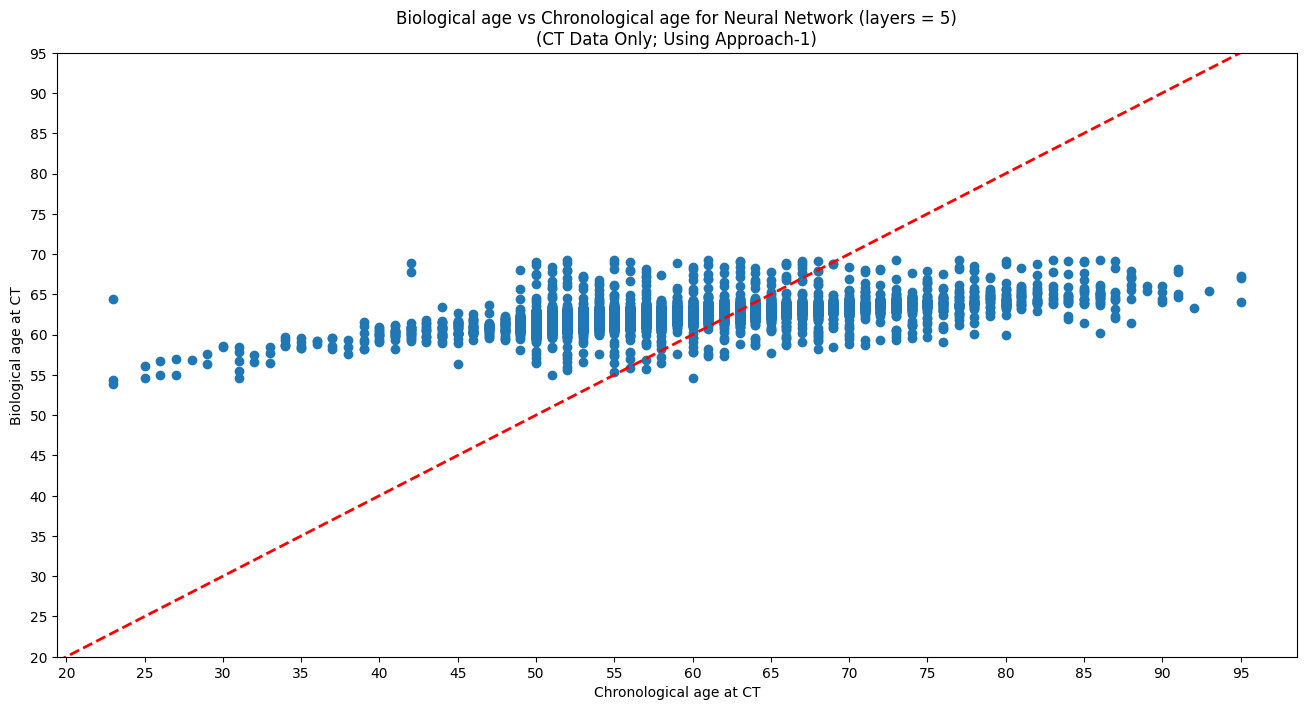

In [ ]:
import numpy as np
import pandas as pd
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

df = pd.read_csv('/content/drive/MyDrive/ML760/dfWithMissingDataFilledKNNv1.csv')

X = df.iloc[:, 0:21].drop(['cl0'], axis=1) # CT + Clinical data
Y = df.iloc[:, 21:22]
chronological_age_at_CT = df['cl4']*365.0

# Data with death label
Y_index = Y.dropna().index
Y_train = Y.loc[Y_index]
X_train = X.loc[Y_index]

# Prediction data
Y_pred_index = Y[Y['y0'].isnull()].index
X_pred = X.iloc[Y_pred_index]

layers = 5
hidden_layer_sizes = []
for j in range(layer):
    hidden_layer_sizes.append(per_layer_neurons)
# Train a neural network
regressor = MLPRegressor(hidden_layer_sizes = tuple(hidden_layer_sizes),  max_iter= 500)
regressor.fit(X_train, Y_train)

for idx in Y_pred_index:
    y_pred = regressor.predict(X_pred.loc[idx:idx+1])
    Y.loc[idx, 'y0'] = y_pred[0]

# Chronological Age [at Death] values
chronological_age_at_death = chronological_age_at_CT + Y['y0']

# Biological Age [at CT] values
biological_age_at_CT = chronological_age_at_CT * (biological_age_at_death / chronological_age_at_death)

# Loss
loss = custom_loss(np.array(biological_age_at_CT), np.array(chronological_age_at_CT))
print(f'Loss for layers={layers} is {round(loss,2)}')

fig, ax = plt.subplots(1, figsize=(16, 8), dpi=100)
ax.scatter(np.array(chronological_age_at_CT) / 365.0, biological_age_at_CT / 365.0)
plt.xticks(np.arange(20, 100, 5))
plt.yticks(np.arange(20, 100, 5))
plt.xlabel("Chronological age at CT")
plt.ylabel("Biological age at CT")
plt.title(f'Biological age vs Chronological age for Neural Network (layers = {layers})\n(CT Data Only; Using Approach-1)')
xpoints = ypoints = ax.get_xlim()
ax.plot(xpoints, ypoints, linestyle='--', color='red', lw=2, scalex=False, scaley=False)
plt.show()

# Chronological age prediction using Linear Regression

*   We are using Linear Regression to predict the chronological age at death.
*  After that we will use the predicted age at death to calculate the biological age at CT
*  Lastly we will use the custom loss function to see how good the model fit with the assumptions/intuition 

# Model using only CT Values

Model Intercept: [2203.57507218]
Model Coeffients: [[-1.17891384e+00  2.60142579e+00 -2.85386542e+00  1.57575158e+00
   3.73256642e-01 -5.31326645e+01  5.22971289e+00  5.96604608e+00
  -7.12046848e+00 -4.86963123e-02  7.03590502e+00]]
Loss is 15.75


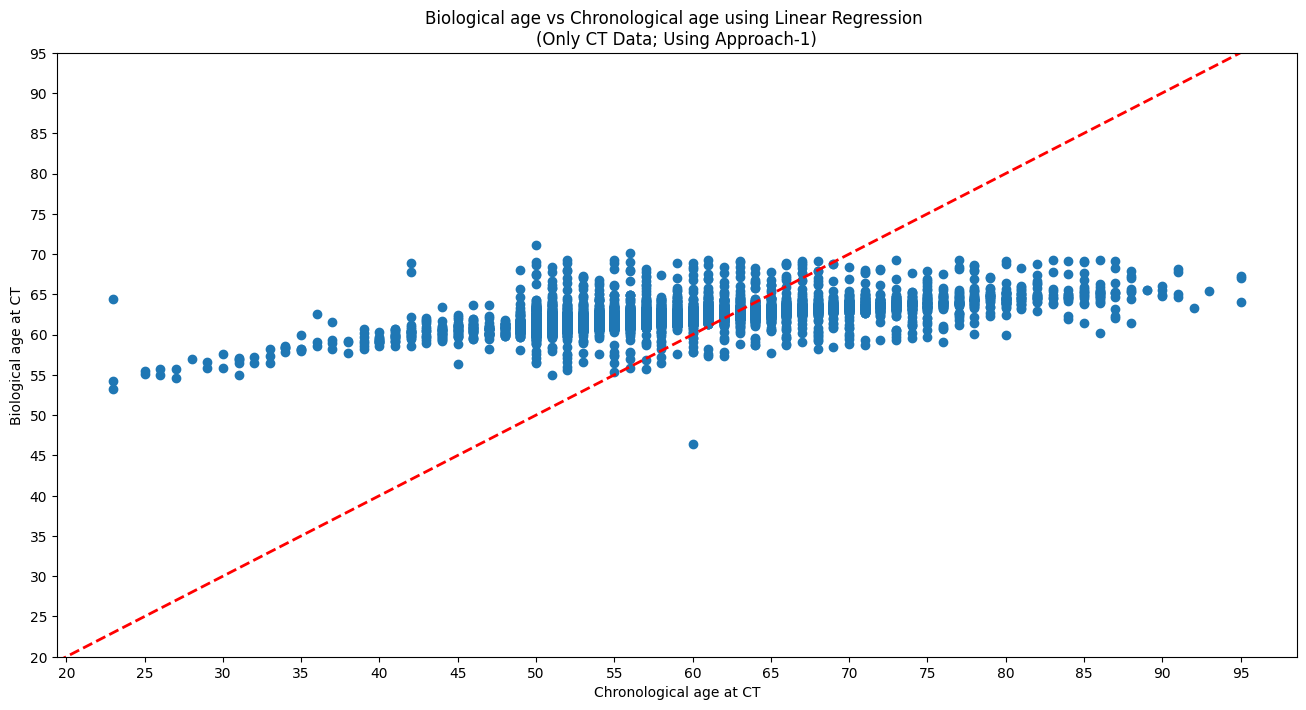

In [ ]:
#getting only CT data
X = df.iloc[:, 0:11]
Y = df.iloc[:, 21:22]

chronological_age_at_CT = df['cl4']*365

#training data
train_index = Y.dropna().index
X_train = X.loc[train_index]
Y_train = Y.loc[train_index]

#testing data
test_index = Y[Y['y0'].isnull()].index
X_test = X.loc[test_index]
Y_test = Y.loc[test_index]

#Linear Regression model
lin_regr = linear_model.LinearRegression()
regr_model = lin_regr.fit(X_train,Y_train)

print("Model Intercept:", regr_model.intercept_)
print("Model Coeffients:", regr_model.coef_)

score = regr_model.score(X_train,Y_train)

for id in test_index:
  y_pred = regr_model.predict(X_test.loc[id:id+1])
  Y.loc[id, 'y0'] = y_pred[0]

#Chronological age at death
chronological_age_at_death = chronological_age_at_CT + Y['y0']

#Biological age during CT
biological_age_at_CT = chronological_age_at_CT * (biological_age_at_death / chronological_age_at_death)

df_final = pd.concat([chronological_age_at_CT / 365.0, biological_age_at_CT / 365.0], axis=1)
df_final = pd.concat([df_final, Y], axis=1)
df_final.columns = ["Chronological Age [at CT]", "Biological Age [at CT]", "Death Days from CT"]

# Loss
loss = custom_loss(np.array(biological_age_at_CT), np.array(chronological_age_at_CT))
print(f'Loss is {round(loss,2)}')

fig, ax = plt.subplots(1, figsize=(16, 8), dpi=100)
ax.scatter(np.array(chronological_age_at_CT) / 365.0, biological_age_at_CT / 365.0)
plt.xticks(np.arange(20, 100, 5))
plt.yticks(np.arange(20, 100, 5))
plt.xlabel("Chronological age at CT")
plt.ylabel("Biological age at CT")
plt.title(f'Biological age vs Chronological age using Linear Regression \n(Only CT Data; Using Approach-1)')
xpoints = ypoints = ax.get_xlim()
ax.plot(xpoints, ypoints, linestyle='--', color='red', lw=2, scalex=False, scaley=False)
plt.show()

# Model using CT + Clinical Data (without follow-up)

Model Intercept: [-29.49217734]
Model Coeffients: [[-3.16609403e-01  1.21637508e-01 -4.57782997e-02 -1.02556967e-01
  -2.45870059e-01  1.68075011e+00  2.38898410e+00 -4.08460371e-01
   4.73406766e-01 -8.82588094e-04 -3.03741299e+00 -1.99416748e+00
   2.89266546e+01  2.92800601e+00  2.02697484e+01  4.90531650e+01
  -2.24855818e+02  1.75199418e-01  1.46520844e+00  5.62284066e+01]]
Loss is 32.19


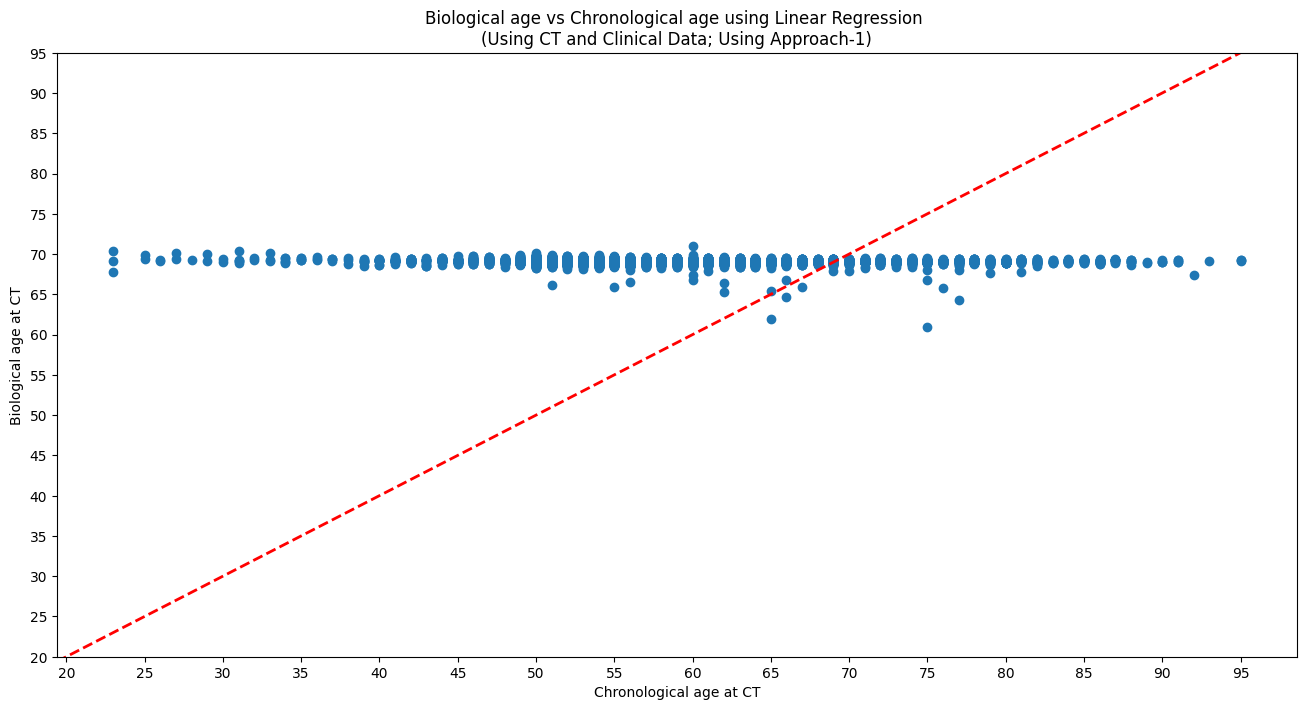

In [ ]:
df.loc[df['cl0'] > df['y0'], 'cl0'] = df['y0'] # Making sure follow-up not less than death

# Training model with CT and Clinical data
X = df.iloc[:, 0:21].drop(columns=['cl0'])
Y = df.iloc[:, 21:22]
Y['y0'] = Y['y0'] - df['cl0']
chronological_age_at_CT = df['cl4']*365.0
clinical_follow_up_date = df['cl0']

#training data
train_index = Y.dropna().index
X_train = X.loc[train_index]
Y_train = Y.loc[train_index]

#testing data
test_index = Y[Y['y0'].isnull()].index
X_test = X.loc[test_index]
Y_test = Y.loc[test_index]

#Linear Regression model
lin_regr = linear_model.LinearRegression()
regr_model = lin_regr.fit(X_train,Y_train)

print("Model Intercept:", regr_model.intercept_)
print("Model Coeffients:", regr_model.coef_)

score = regr_model.score(X_train,Y_train)

for id in test_index:
  y_pred = regr_model.predict(X_test.loc[id:id+1])
  Y.loc[id, 'y0'] = y_pred[0]

#Chronological age at death
chronological_age_at_death = chronological_age_at_CT + Y['y0']

#Biological age during CT
biological_age_at_CT = chronological_age_at_CT * (biological_age_at_death / chronological_age_at_death)

df_final = pd.concat([chronological_age_at_CT / 365.0, biological_age_at_CT / 365.0], axis=1)
df_final = pd.concat([df_final, Y], axis=1)
df_final.columns = ["Chronological Age [at CT]", "Biological Age [at CT]", "Death Days from CT"]

# Loss
loss = custom_loss(np.array(biological_age_at_CT), np.array(chronological_age_at_CT))
print(f'Loss is {round(loss,2)}')

fig, ax = plt.subplots(1, figsize=(16, 8), dpi=100)
ax.scatter(np.array(chronological_age_at_CT) / 365.0, biological_age_at_CT / 365.0)
plt.xticks(np.arange(20, 100, 5))
plt.yticks(np.arange(20, 100, 5))
plt.xlabel("Chronological age at CT")
plt.ylabel("Biological age at CT")
plt.title(f'Biological age vs Chronological age using Linear Regression \n(Using CT and Clinical Data; Using Approach-1)')
xpoints = ypoints = ax.get_xlim()
ax.plot(xpoints, ypoints, linestyle='--', color='red', lw=2, scalex=False, scaley=False)
plt.show()

# Model using CT + Clinical Data (with follow-up)

Model Intercept: [48.86553973]
Model Coeffients: [[-3.33478849e-01  1.89688248e-01 -1.03517247e-01 -6.50755498e-02
  -2.55749135e-01  5.34239040e-02  2.56782877e+00 -1.36062844e-01
   5.20824927e-02 -2.21622181e-03 -2.77699785e+00  9.73049634e-01
  -2.25707356e+00  1.83762570e+01  3.02285637e+00  7.62361480e+00
   4.44366642e+01 -1.69685261e+02  6.32530742e-01  6.79080177e-01
   5.79197083e+01]]
Loss is 18.53


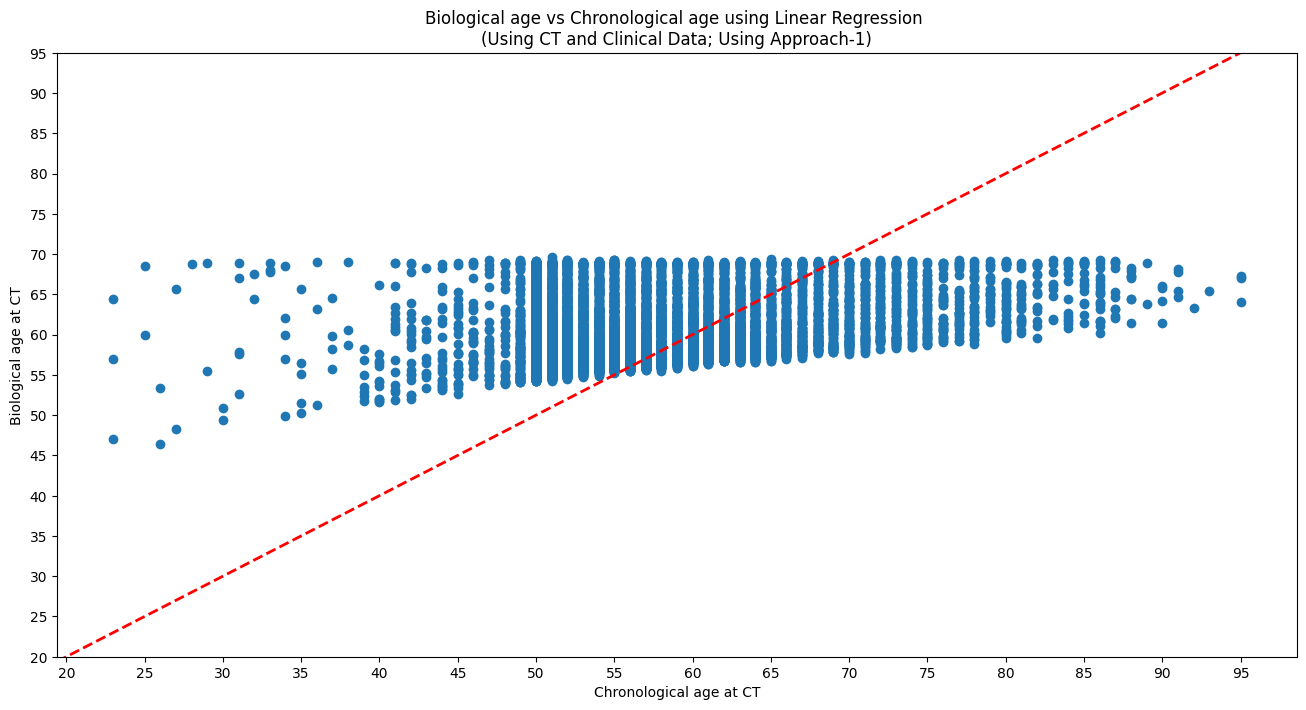

In [ ]:
# Training model with CT and Clinical data
X = df.iloc[:, 0:21]
Y = df.iloc[:, 21:22]
chronological_age_at_CT = df['cl4']*365.0

#training data
train_index = Y.dropna().index
X_train = X.loc[train_index]
Y_train = Y.loc[train_index]

#testing data
test_index = Y[Y['y0'].isnull()].index
X_test = X.loc[test_index]
Y_test = Y.loc[test_index]

#Linear Regression model
lin_regr = linear_model.LinearRegression()
regr_model = lin_regr.fit(X_train,Y_train)

print("Model Intercept:", regr_model.intercept_)
print("Model Coeffients:", regr_model.coef_)

score = regr_model.score(X_train,Y_train)

for id in test_index:
  y_pred = regr_model.predict(X_test.loc[id:id+1])
  Y.loc[id, 'y0'] = y_pred[0]

#Chronological age at death
chronological_age_at_death = chronological_age_at_CT + Y['y0']

#Biological age during CT
biological_age_at_CT = chronological_age_at_CT * (biological_age_at_death / chronological_age_at_death)

df_final = pd.concat([chronological_age_at_CT / 365.0, biological_age_at_CT / 365.0], axis=1)
df_final = pd.concat([df_final, Y], axis=1)
df_final.columns = ["Chronological Age [at CT]", "Biological Age [at CT]", "Death Days from CT"]

# Loss
loss = custom_loss(np.array(biological_age_at_CT), np.array(chronological_age_at_CT))
print(f'Loss is {round(loss,2)}')

fig, ax = plt.subplots(1, figsize=(16, 8), dpi=100)
ax.scatter(np.array(chronological_age_at_CT) / 365.0, biological_age_at_CT / 365.0)
plt.xticks(np.arange(20, 100, 5))
plt.yticks(np.arange(20, 100, 5))
plt.xlabel("Chronological age at CT")
plt.ylabel("Biological age at CT")
plt.title(f'Biological age vs Chronological age using Linear Regression \n(Using CT and Clinical Data; Using Approach-1)')
xpoints = ypoints = ax.get_xlim()
ax.plot(xpoints, ypoints, linestyle='--', color='red', lw=2, scalex=False, scaley=False)
plt.show()